In [1]:
import matplotlib.pyplot as plt

### Description:
This first cell plots the data we gathered from our entire doublet test.

Note: This control system is an integrating system and our actuator is currently on/off. Thus the actuator command is not proportional to the error right now. (We may make crane motor speed a variable quantity later.)

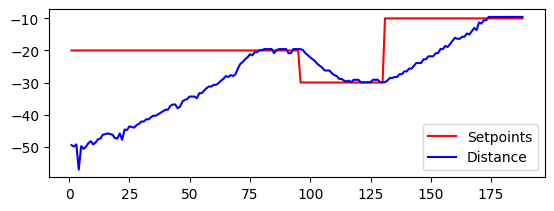

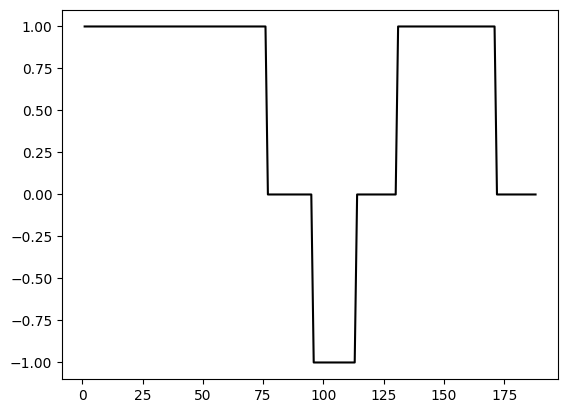

In [2]:
#modified to use Taylor's data from finaly.csv

with open("finaly.csv", "r") as f:
    times = []
    setpoints = []
    distance = []
    actuator = []

    for i, line in enumerate(f.readlines()):
        if "timestamp" in line:
            continue
        else:
            # try:
            values = line.split(",")
            setpoints.append(-1*int(values[1]))
            # if distance != None: #why this
            distance.append(-1*float(values[2]))
            # else:
            #     distance.append(0)
            # actuator.append(str(values[3])) 
            # print(str(values[3]))           
            if str(values[3]) == "raise\n":
                actuator.append(1)
            elif str(values[3]) == "lower\n":
                actuator.append(-1)
            else:
                actuator.append(0)
            times.append(i)
            # except:
                
                # break
            
plt.subplot(2, 1, 1)
plt.plot(times, setpoints, "r", label = "Setpoints")
plt.plot(times, distance, "b", label = "Distance")
plt.grid()
plt.legend()
# plt.subplot(2, 1, 2)
plt.grid()
plt.legend()
plt.show()
plt.plot(times, actuator, "k", label = "Motor Direction")


### Step Test FOPDT fit:

The below plot shows the last chunk of our doublet test, where we had one setpoint change and we watch the control response and measure its time constants. Note that the gain is incorrect - for an integrating system, gain is conceptually infinite.

20.0 The deltaU value that is hidden, which I need
Estimated gain (Kp) = 0.9704 Note - gain for integrating system is conceptually infinite.
Estimated time constant (tau_p) = 24.0000
Estimated dead time (theta_p) = 4.0000


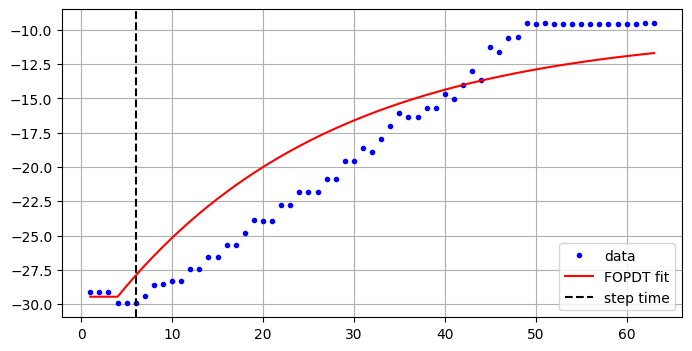

In [7]:
import numpy as np
from scipy.optimize import curve_fit

#fitting the csv data to the FOPDT model with a regression... it's gonna be very bad

with open("C:/Users/andre/OneDrive/Desktop/CH EN 436 Controls/Project/Controls-Project-Crane-Style/finaly modified.csv", "r") as f:
    times = []
    setpoints = []
    distance = []
    actuator = []

    for i, line in enumerate(f.readlines()):
        if "timestamp" in line:
            continue
        else:
            # try:
            values = line.split(",")
            setpoints.append(-1*int(values[1]))
            # if distance != None: #why this
            distance.append(-1*float(values[2]))
            # else:
            #     distance.append(0)
            # actuator.append(str(values[3])) #changing this to get number values for the actuator motion
            if str(values[3]) == "raise\n":
                actuator.append(int(1))
            elif str(values[3]) == "lower\n":
                actuator.append(int(1))
            else:
                actuator.append(0)
            times.append(i)

t = np.array(times, dtype=float)
y = np.array(distance, dtype=float)
sp = np.array(setpoints, dtype=float)

# find a step in the setpoint (use the first non-zero change or the largest change)
dsp = np.diff(sp)
if np.any(dsp != 0):
    step_idx = np.where(dsp != 0)[0][0] + 1 #this line is really important. Records where steps happen
else:
    # fallback to largest change (or raise if truly constant)
    if np.all(dsp == 0):
        raise RuntimeError("No setpoint step detected in setpoints.")
    step_idx = np.argmax(np.abs(dsp)) + 1

t_step = t[step_idx]
delta_u = float(sp[step_idx] - sp[step_idx - 1]) #makes delta_U here, important line. 
# This is treating the setpoint change as equal to the controller output change (almost like proportional control)
print(delta_u,'The deltaU value that is hidden, which I need')

# reasonable baseline and final value estimates
pre_window = max(1, min(10, step_idx))
y0 = np.mean(y[max(0, step_idx - pre_window):step_idx]) #making decent guesses
y_inf = np.mean(y[-min(20, len(y)) :])

# initial guesses
K_init = (y_inf - y0) / (delta_u if delta_u != 0 else 1.0)
# estimate deadtime: first time after step where response departs by 5% of full change
threshold = 0.05 * abs(y_inf - y0)
post_idx = np.arange(step_idx, len(y))
theta_init = 0.0
for ii in post_idx:
    if abs(y[ii] - y0) >= threshold:
        theta_init = max(0.0, t[ii] - t_step)
        break
# time constant initial: when reaches 63.2% after theta
t63_target = y0 + 0.632 * (y_inf - y0)
tau_init = (t[-1] - t_step) / 3.0
for ii in post_idx:
    if t[ii] - t_step <= theta_init:
        continue
    if (y_inf - y0) == 0:
        continue
    if (y[ii] - y0) * np.sign(y_inf - y0) >= (t63_target - y0) * np.sign(y_inf - y0):
        tau_init = max(1e-3, (t[ii] - t_step) - theta_init)
        break

# FOPDT model: y(t) = y0 + K * delta_u * (1 - exp(-(t - theta)/tau)) for t>=theta, else y0
def fopdt(t_arr, K, tau, theta, y0_param, delta_u):
    t_arr = np.asarray(t_arr) #type change
    resp = np.ones_like(t_arr) * y0_param #
    t_eff = t_arr - theta
    positive = t_eff > 0 #cuts the dead time off, makes a new set of counts to iterate over
    resp[positive] = y0_param + K * delta_u * (1.0 - np.exp(-t_eff[positive] / tau))
    return resp

p0 = [K_init, max(1e-3, tau_init), max(0.0, theta_init), y0]
# bounds to keep parameters reasonable
max_t = float(t[-1] - t_step) + float(t_step)
bounds = (
    [-1000.0, 1e-6, 0.0, min(y) - 1000.0],  # lower
    [1000.0, max_t * 10.0, max_t, max(y) + 1000.0],  # upper
)

try:
    popt, pcov = curve_fit(fopdt, t, y, p0=p0, bounds=bounds, maxfev=10000)
except Exception:
    # fallback to initial estimates if fit fails
    popt = np.array(p0)

K_fit, tau_fit, theta_fit, y0_fit = popt
gain = K_fit  # process gain (y change per unit input change)
tau_p = tau_fit
theta_p = theta_fit

# print results
print(f"Estimated gain (Kp) = {gain:.4f} Note - gain for integrating system is conceptually infinite.")
print(f"Estimated time constant (tau_p) = {tau_p:.4f}")
print(f"Estimated dead time (theta_p) = {theta_p:.4f}")

# plot data and fit
y_fit = fopdt(t, K_fit, tau_fit, theta_fit, y0_fit, delta_u)
plt.figure(figsize=(8,4))
plt.plot(t, y, "b.", label="data")
plt.plot(t, y_fit, "r-", label="FOPDT fit")
plt.axvline(t_step, color="k", linestyle="--", label="step time")
plt.legend()
plt.grid(True)
plt.show()

# Step Test Modeling

Important to note here - I learned through this homework that using an FOPDT model for the system as we've currently designed it doesn't make sense.
Our controller meets a setpoint by doing on/off control. It currently has no capacity for a numerical error response or a variable controller output. These need to change in order to meet the project guidelines and requirements. We will have a turning point when we meet as a group on Monday and future assignments will be different.
However, for this homework I'm just going to submit a step response simulation based on the results we have right now. Is it 100% accurate? No, but it's doing the same amount of work as everyone else.

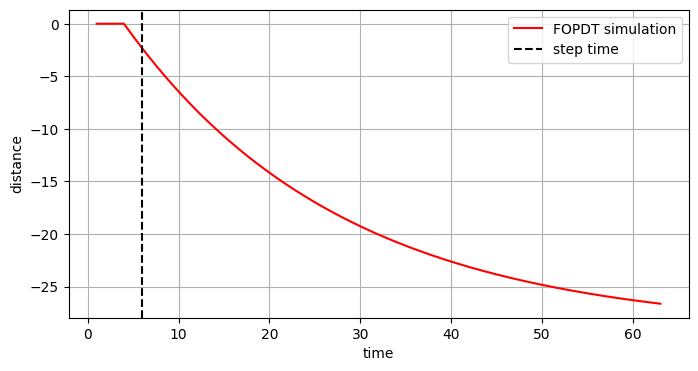

RMSE between measured and simulated response: 2.6445


In [23]:
#we just plotted a fit from the FOPDT model above. It's obvious to me that the model isn't a correct description, but that's fine right now.
#I'll make a physics based simulation later, I hope. I just need to simulate a step test and turn it in.

# simulate step response using fitted FOPDT params and compare to data
t_sim = np.linspace(float(t[0]), float(t[-1]), 500)
y_sim = fopdt(t_sim, gain, tau_p, theta_p, 0, -30)

# plot
plt.figure(figsize=(8,4))
# plt.plot(t, y, "b.", label="measured")
plt.plot(t_sim, y_sim, "r-", label="FOPDT simulation")
plt.axvline(t_step, color="k", linestyle="--", label="step time")
plt.xlabel("time")
plt.ylabel("distance")
plt.legend()
plt.grid(True)
plt.show()

# quantify fit
y_model_at_data = fopdt(t, gain, tau_p, theta_p, -30, 20)
rmse = np.sqrt(np.mean((y - y_model_at_data)**2))
print(f"RMSE between measured and simulated response: {rmse:.4f}")
#not useful because it only fits against the first data from last time.


#I'm strategizing here, this is starting to be more fun and less stress. Sorta. Let's keep chugging.
# So the current system calls the controller output response equal to the setpoint change - as if it wasn't an integrating system.
# That's actually an interesting control model, some things should be run that way.
# but our system needs to follow a different control strategy.
# Huh, ours is the straight-up simplest control you could ever ask for. It isn't dynamic or really sensing - just a comparator robot.

### Brief explanation of the fit

The FOPDT fit doesn't need to calculate the gain since we're using an integrating system.<br>
Our control isn't at its most sophisticated yet, but we will improve upon it if we have time later.<br>
The fit seems to have a low amount of error - the system response is described well by the FOPDT model.

## Step Test Simulation
<p>
Thinking strategy right now...
Dr. Hedengren asks us to submit a simulated step response using our data-driven or physics based model.
For us, that can be as easy as simulating a response with our FOPDT parameters.<p>

<h4>
Thinking point: How to model a system with infinite gain using FOPDT?<h4>

In terms of words solving the problem - the things we observed are not really a dynamic actuator response. The actuator response will always move as fast as it can, and the time to 63% will always be strictly dependent on that constant speed and the distance required to travel.

### Physics based instead of FOPDT:
<p>
Will the TAs care that we switch model types? I strongly doubt it, they don't compare every one of our assignments to the last.
How does a physics based model help us? Because the response can be easily predicted using pure kinematics. No force balances needed, no steady-state approach or dynamic responses in the system.

Which leads me back to (briefly), we could make the rate of winch winding a PWM variable speed thing. No one is stopping us. It only takes a bit more work on the microcontroller code. And good planning for final use case.


What physics parameters are needed? 1- crane raise/lower speed. Does one direction go faster than the other? Our base speed is measurable, or was when we used a set runtime and a low voltage battery. I bet our speed is measurable now.
#### However
The crane wind rate varies a little bit with length of cable (distance out).
I bet this will average out.


OK, staying focused. 
Parameters:
* winch cable rates, up and down
* reasonable max and min for crane distance
* is there a dead time?



<p>